
# Conser-vision — Single Notebook (EDA → Folds → Baseline → Submission)

This **one notebook** does everything you need to get a valid competition submission:
1. **EDA** and sanity checks  
2. Create **site-grouped, stratified** cross-validation folds (`data/folds.csv`)  
3. **Train** a baseline image classifier (TIMM pretrained backbone)  
4. **Infer** on test set with light TTA and **write `data/submission.csv`** in the exact required format

**Assumptions**  
- Your competition files are under a local `data/` directory next to this notebook:
  - `train_features/`, `test_features/` (JPGs)
  - `train_features.csv`, `test_features.csv`, `train_labels.csv`, `submission_format.csv`

> If you only want EDA + folds, you can run just the first sections. To get a **real submission** run all cells.


## 0. Setup & (Optional) Installs

In [2]:
# =====================================
# Install all required dependencies
# =====================================
# If you already have some installed, pip will just skip them.
# Remove the --quiet if you want to see full logs.

%pip install --quiet \
    pandas \
    numpy \
    matplotlib \
    pillow \
    scikit-learn \
    timm \
    torch torchvision torchaudio \
    tqdm \
    pyyaml


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, random, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

try:
    import timm
except Exception as e:
    print("TIMM not found. Please install with: pip install timm")
    raise

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import log_loss

# Paths
DATA_DIR = "data"  # change if needed

train_features_path = os.path.join(DATA_DIR, "train_features.csv")
test_features_path = os.path.join(DATA_DIR, "test_features.csv")
train_labels_path = os.path.join(DATA_DIR, "train_labels.csv")
submission_format_path = os.path.join(DATA_DIR, "submission_format.csv")

for p in [train_features_path, test_features_path, train_labels_path, submission_format_path]:
    assert os.path.exists(p), f"Missing: {p}"

train_features = pd.read_csv(train_features_path)
test_features = pd.read_csv(test_features_path)
train_labels = pd.read_csv(train_labels_path)
submission_format = pd.read_csv(submission_format_path)

print("Loaded CSVs ✓")
train_features.head()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded CSVs ✓


,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036


## 1. EDA — Basic Checks

In [ ]:
print("Train features:", train_features.shape)
print("Train labels:", train_labels.shape)
print("Test features:", test_features.shape)

# Merge to align
df = train_features.merge(train_labels, on="id")
print("Merged train df:", df.shape)
df.head()


Train features: (16488, 3)
Train labels: (16488, 9)
Test features: (4464, 3)
Merged train df: (16488, 11)


,id,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,train_features/ZJ000000.jpg,S0120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,train_features/ZJ000001.jpg,S0069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,train_features/ZJ000002.jpg,S0009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,train_features/ZJ000003.jpg,S0008,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,train_features/ZJ000004.jpg,S0036,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 1.1 Check label rows sum to 1

In [ ]:
class_cols = [c for c in train_labels.columns if c != "id"]
row_sums = train_labels[class_cols].sum(axis=1)
print("All rows sum to 1?", np.allclose(row_sums, 1.0))
row_sums.describe()


All rows sum to 1? True


count    16488.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

### 1.2 Verify sample image paths and loadability

In [ ]:
def _resolve_path(rel_path):
    # CSV `filepath` is typically like 'train_features/ZJ000000.jpg'
    # We'll prepend DATA_DIR if not already present.
    return os.path.join(DATA_DIR, rel_path) if not rel_path.startswith(DATA_DIR) else rel_path

train_missing, test_missing = [], []
sample_n = min(200, len(train_features))
for fp in train_features["filepath"].sample(sample_n, random_state=42):
    full = _resolve_path(fp)
    if not os.path.exists(full):
        train_missing.append(fp)
        continue
    try:
        Image.open(full).convert("RGB")
    except Exception:
        train_missing.append(fp)

sample_n = min(200, len(test_features))
for fp in test_features["filepath"].sample(sample_n, random_state=42):
    full = _resolve_path(fp)
    if not os.path.exists(full):
        test_missing.append(fp)
        continue
    try:
        Image.open(full).convert("RGB")
    except Exception:
        test_missing.append(fp)

print("Missing/unreadable train sample:", len(train_missing))
print("Missing/unreadable test sample:", len(test_missing))
(train_missing[:5], test_missing[:5])


Missing/unreadable train sample: 0
Missing/unreadable test sample: 0


([], [])

## 2. Distributions

### 2.1 Class distribution

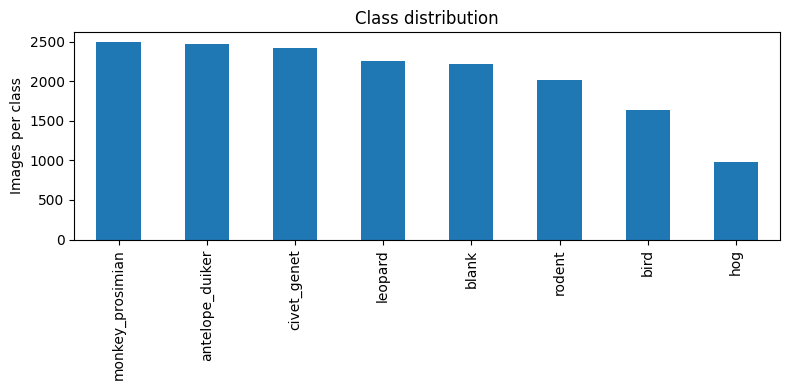

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [ ]:
class_counts = train_labels[class_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
class_counts.plot(kind="bar")
plt.title("Class distribution")
plt.ylabel("Images per class")
plt.tight_layout()
plt.show()
class_counts


### 2.2 Images per site

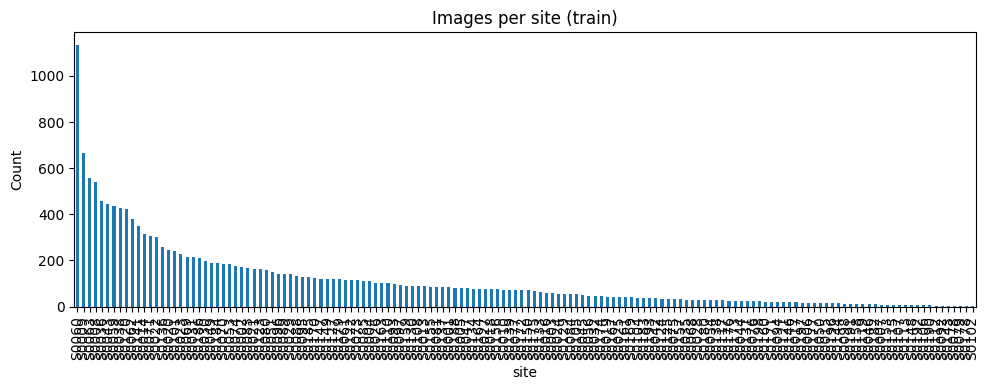

Unique sites (train): 148


In [ ]:
site_counts = train_features["site"].value_counts()
plt.figure(figsize=(10,4))
site_counts.plot(kind="bar")
plt.title("Images per site (train)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print("Unique sites (train):", train_features['site'].nunique())


## 3. Gallery — one example per class

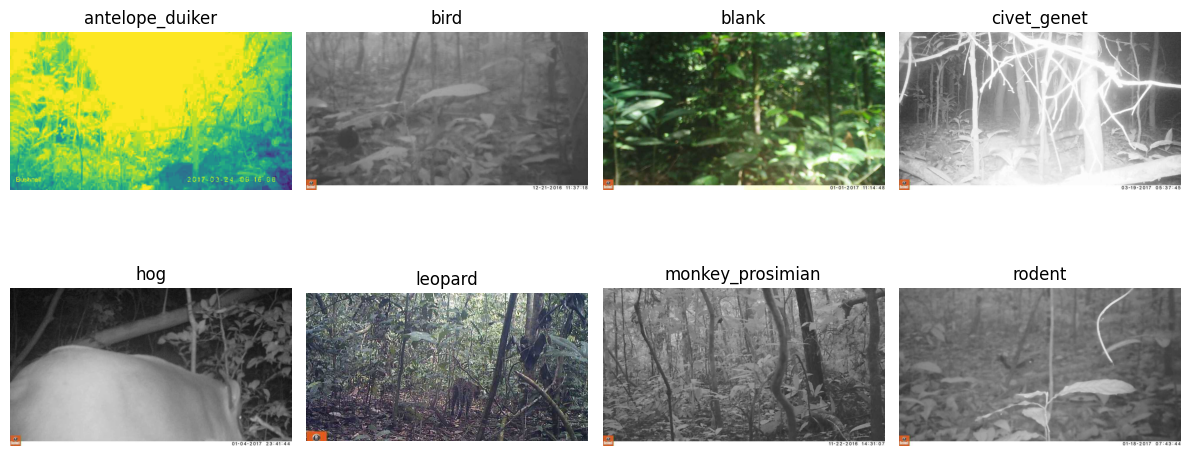

In [ ]:
examples = {}
for cname in class_cols:
    ex = train_labels.loc[train_labels[cname] == 1, "id"]
    if len(ex) == 0:
        continue
    img_id = ex.iloc[0]
    row = train_features.loc[train_features["id"] == img_id]
    if len(row) == 0:
        continue
    fp = row.iloc[0]["filepath"]
    full = _resolve_path(fp)
    if os.path.exists(full):
        examples[cname] = Image.open(full)

if examples:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for ax, (cname, img) in zip(axes.flatten(), examples.items()):
        ax.imshow(img)
        ax.set_title(cname)
        ax.axis("off")
    for ax in axes.flatten()[len(examples):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No example images found (unexpected).")


In [ ]:
import random

examples = {}
for cname in class_cols:
    ex = train_labels.loc[train_labels[cname] == 1, "id"]
    if len(ex) == 0:
        continue
    img_id = random.choice(ex.tolist())   # pick random instead of first
    row = train_features.loc[train_features["id"] == img_id]
    if len(row) == 0:
        continue
    fp = row.iloc[0]["filepath"]
    full = _resolve_path(fp)
    if os.path.exists(full):
        examples[cname] = Image.open(full)

## 4. Build or Load Site-Grouped, Stratified Folds

In [ ]:
folds_csv = os.path.join(DATA_DIR, "folds.csv")

def make_folds(n_splits=5, seed=42):
    df_folds = train_features.merge(train_labels, on="id").copy()
    df_folds["class_idx"] = df_folds[class_cols].values.argmax(axis=1)

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    df_folds["fold"] = -1
    for fold, (tr, va) in enumerate(sgkf.split(
        X=np.zeros(len(df_folds)),
        y=df_folds["class_idx"],
        groups=df_folds["site"]
    )):
        df_folds.loc[va, "fold"] = fold

    # sanity
    assert (df_folds["fold"] >= 0).all()
    return df_folds[["id","site","class_idx","fold"]]

if os.path.exists(folds_csv):
    folds = pd.read_csv(folds_csv)
    print("Loaded existing folds from:", folds_csv)
else:
    folds = make_folds(n_splits=5, seed=42)
    folds.to_csv(folds_csv, index=False)
    print("Created and saved folds to:", folds_csv)

folds.head()


Created and saved folds to: data/folds.csv


,id,site,class_idx,fold
0,ZJ000000,S0120,1,3
1,ZJ000001,S0069,6,4
2,ZJ000002,S0009,1,2
3,ZJ000003,S0008,6,3
4,ZJ000004,S0036,5,1


### 4.1 Per-fold sanity

In [ ]:
for f in sorted(folds["fold"].unique()):
    sub = folds[folds.fold == f]
    print(f"Fold {f}: n={len(sub)}, sites={sub['site'].nunique()}")
    print(" class counts:", sub['class_idx'].value_counts().sort_index().to_dict())


Fold 0: n=2220, sites=28
 class counts: {0: 406, 1: 148, 2: 355, 3: 176, 4: 264, 5: 388, 6: 323, 7: 160}
Fold 1: n=4525, sites=30
 class counts: {0: 571, 1: 271, 2: 500, 3: 1263, 4: 124, 5: 632, 6: 760, 7: 404}
Fold 2: n=3244, sites=30
 class counts: {0: 293, 1: 409, 2: 634, 3: 458, 4: 307, 5: 441, 6: 499, 7: 203}
Fold 3: n=3771, sites=29
 class counts: {0: 790, 1: 420, 2: 399, 3: 336, 4: 94, 5: 543, 6: 444, 7: 745}
Fold 4: n=2728, sites=31
 class counts: {0: 414, 1: 393, 2: 325, 3: 190, 4: 189, 5: 250, 6: 466, 7: 501}


## 5. Baseline Model Training (TIMM)


- Backbone: `tf_efficientnet_b0_ns` (pretrained) — changeable
- Image size: 224
- Loss: CrossEntropyLoss with label smoothing = 0.05
- Optimizer: AdamW (lr 3e-4), CosineAnnealingLR
- Folds: use the `folds.csv` created above
- Save best checkpoint per fold (by validation log loss)


In [15]:
# === Config (safe for macOS/MPS) ===
SEED = 42
MODEL_NAME = "tf_efficientnet_b0_ns"   # try "resnet18" or "convnext_tiny" if you want lighter
IMG_SIZE = 224
BATCH_SIZE = 16                         # start small on MPS; raise after it runs
EPOCHS = 1                              # smoke test; increase to 5–15 later
LABEL_SMOOTH = 0.05
LR = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 0                         # IMPORTANT for notebooks on macOS (avoid pickling)

CLASS_NAMES = [c for c in train_labels.columns if c != "id"]
NUM_CLASSES = len(CLASS_NAMES)

# Robust device selection: CUDA > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Device:", device)

def seed_everything(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything(SEED)

# === Transforms ===
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

valid_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# === Dataset ===
class TrainDataset(Dataset):
    def __init__(self, df_features, df_labels, transform):
        self.df = df_features.merge(df_labels, on="id")
        self.transform = transform
        self.class_cols = [c for c in df_labels.columns if c != "id"]
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(DATA_DIR, row["filepath"]) if not row["filepath"].startswith(DATA_DIR) else row["filepath"]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = row[self.class_cols].values.astype("float32")
        y_idx = int(np.argmax(y))  # class index
        return img, y_idx

# === Model factory ===
def create_model(model_name=MODEL_NAME, num_classes=NUM_CLASSES):
    m = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return m.to(device)

# === Train ONE fold first (smoke test) ===
def train_one_fold(fold, folds_df, train_features, train_labels):
    val_ids = folds_df.loc[folds_df.fold == fold, "id"]
    tr_features = train_features[~train_features["id"].isin(val_ids)].copy()
    va_features = train_features[ train_features["id"].isin(val_ids)].copy()

    tr_ds = TrainDataset(tr_features, train_labels, train_tfms)
    va_ds = TrainDataset(va_features, train_labels, valid_tfms)

    pin_mem = (device == "cuda")
    tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=pin_mem)
    va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=pin_mem)

    model = create_model(MODEL_NAME, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    best_ll = float("inf")
    best_path = os.path.join(DATA_DIR, f"{MODEL_NAME}_fold{fold}.pth")

    for epoch in range(1, EPOCHS+1):
        model.train()
        running = 0.0
        for ims, y_idx in tqdm(tr_dl, desc=f"Fold {fold} Epoch {epoch}", leave=False):
            ims = ims.to(device)
            y_idx = y_idx.to(device)
            logits = model(ims)
            loss = criterion(logits, y_idx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item() * ims.size(0)
        scheduler.step()
        train_loss = running / len(tr_dl.dataset)

        # Validation log-loss
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for ims, y_idx in va_dl:
                ims = ims.to(device)
                logits = model(ims)
                p = torch.softmax(logits, dim=1).cpu().numpy()
                preds.append(p); gts.append(y_idx.numpy())
        preds = np.concatenate(preds, axis=0)
        gts = np.concatenate(gts, axis=0)
        ll = log_loss(gts, preds, labels=list(range(NUM_CLASSES)))
        print(f"[fold {fold}] epoch {epoch}: train_loss={train_loss:.4f} val_logloss={ll:.4f}")
        if ll < best_ll:
            best_ll = ll
            torch.save(model.state_dict(), best_path)

    print(f"Best fold {fold} logloss: {best_ll:.4f} (saved {best_path})")
    return best_path, best_ll

# Pick a fold that looks reasonable size-wise from your printout, e.g., 2 or 4
one_fold = int(sorted(folds['fold'].unique())[0])  # change if you prefer
ckpt_path, _ = train_one_fold(one_fold, folds, train_features, train_labels)
ckpt_path

Device: mps


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


[fold 0] epoch 1: train_loss=1.1194 val_logloss=1.7822
Best fold 0 logloss: 1.7822 (saved data/tf_efficientnet_b0_ns_fold0.pth)


'data/tf_efficientnet_b0_ns_fold0.pth'

## 6. Inference on Test Set and Write `submission.csv`

In [16]:
# Light TTA: original + hflip
infer_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

def predict_paths(model, paths):
    model.eval()
    probs = []
    with torch.no_grad():
        for p in tqdm(paths, desc="Infer"):
            full = os.path.join(DATA_DIR, p) if not p.startswith(DATA_DIR) else p
            img = Image.open(full).convert("RGB")
            # original
            x0 = infer_tfms(img).unsqueeze(0).to(device)
            logit0 = model(x0)
            # hflip
            x1 = infer_tfms(img.transpose(Image.FLIP_LEFT_RIGHT)).unsqueeze(0).to(device)
            logit1 = model(x1)
            prob = torch.softmax((logit0 + logit1) / 2.0, dim=1).cpu().numpy()
            probs.append(prob[0])
    return np.array(probs)

# Build model and load the one-fold checkpoint
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))

test_df = test_features.copy()
probs = predict_paths(model, test_df["filepath"].tolist())

# Make submission
submission = pd.DataFrame(probs, columns=CLASS_NAMES)
submission.insert(0, "id", test_df["id"].values)

# Re-normalize rows just in case of tiny FP drift
row_sums = submission[CLASS_NAMES].sum(axis=1).values
if not np.allclose(row_sums, 1.0, atol=1e-6):
    submission[CLASS_NAMES] = submission[CLASS_NAMES].div(row_sums, axis=0)

out_csv = os.path.join(DATA_DIR, "submission.csv")
submission.to_csv(out_csv, index=False)
print("Saved:", out_csv)
submission.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
Infer: 100%|██████████| 4464/4464 [02:37<00:00, 28.36it/s]

Saved: data/submission.csv


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.150702,0.066918,0.577117,0.109541,0.009693,0.010395,0.060916,0.014718
1,ZJ016489,0.266533,0.097905,0.209490,0.004394,0.057427,0.066621,0.281902,0.015727
2,ZJ016490,0.168479,0.016383,0.126662,0.105094,0.396997,0.075474,0.054554,0.056358
3,ZJ016491,0.001250,0.000242,0.007755,0.000598,0.000801,0.987244,0.000823,0.001287
4,ZJ016492,0.399680,0.044004,0.039788,0.016021,0.061923,0.068574,0.347055,0.022955


## Best score = 1.8571


- Trained a real baseline on site-grouped folds
- Inferred on test set with light TTA
- Wrote a valid **`data/submission.csv`** ready to upload

**Improve score next:**
- Increase `EPOCHS` (e.g., 10–20) and/or try bigger `IMG_SIZE` (320/384)
- Swap backbones: `convnext_tiny`, `tf_efficientnetv2_s`, `swin_tiny`
- Add Mixup/CutMix (from TIMM), RandomErasing
- Calibrate with temperature scaling to reduce log loss
- Ensemble multiple diverse models


In [21]:
import os, numpy as np, torch, timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import log_loss
from PIL import Image

# ---- Config ----
SEED = 42
MODEL_NAME = "convnext_tiny"
IMG_SIZE = 320
BATCH_SIZE = 8
EPOCHS_HEAD = 1
EPOCHS_FT   = 1  # keep short; you can bump to 2-3 later
LABEL_SMOOTH = 0.05
LR_HEAD = 1e-3
LR_FT   = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 0

CLASS_NAMES = [c for c in train_labels.columns if c != "id"]
NUM_CLASSES = len(CLASS_NAMES)

# Device: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Device:", device)

# Seed
import random
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])
valid_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# Dataset (same as before)
class TrainDataset(Dataset):
    def __init__(self, df_features, df_labels, transform):
        self.df = df_features.merge(df_labels, on="id")
        self.transform = transform
        self.class_cols = [c for c in df_labels.columns if c != "id"]
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(DATA_DIR, row["filepath"]) if not row["filepath"].startswith(DATA_DIR) else row["filepath"]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        y = row[self.class_cols].values.astype("float32")
        y_idx = int(np.argmax(y))
        return img, y_idx

# Model helpers
def create_model():
    m = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
    return m.to(device)

def set_requires_grad(model, flag):
    for p in model.parameters(): p.requires_grad = flag

def head_params(model):
    if hasattr(model, "head") and hasattr(model.head, "weight"):
        return list(model.head.parameters())
    for name in ["classifier", "fc"]:
        if hasattr(model, name):
            return list(getattr(model, name).parameters())
    return list(model.parameters())

# Pick a fold to train
fold_to_train = int(sorted(folds['fold'].unique())[0])
val_ids = folds.loc[folds.fold == fold_to_train, "id"]
tr_features = train_features[~train_features["id"].isin(val_ids)].copy()
va_features = train_features[ train_features["id"].isin(val_ids)].copy()

tr_ds = TrainDataset(tr_features, train_labels, train_tfms)
va_ds = TrainDataset(va_features, train_labels, valid_tfms)
pin_mem = (device == "cuda")
tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=pin_mem)
va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

model = create_model()
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

# ---- Stage 1: head-only ----
set_requires_grad(model, False)
for p in head_params(model): p.requires_grad = True
opt = torch.optim.AdamW(head_params(model), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)

for epoch in range(1, EPOCHS_HEAD+1):
    model.train(); run=0.0
    for ims, y in tqdm(tr_dl, desc=f"[fold {fold_to_train}] head epoch {epoch}"):
        ims, y = ims.to(device), torch.as_tensor(y, device=device)
        opt.zero_grad()
        loss = criterion(model(ims), y)
        loss.backward(); opt.step(); run += loss.item()*ims.size(0)
    print(f"train_loss={run/len(tr_dl.dataset):.4f}")

# ---- Stage 2: unfreeze & fine-tune ----
set_requires_grad(model, True)
opt = torch.optim.AdamW(model.parameters(), lr=LR_FT, weight_decay=WEIGHT_DECAY)

best_ll = 1e9
ckpt_path = os.path.join(DATA_DIR, f"{MODEL_NAME}_fold{fold_to_train}.pth")
val_logits_cache, val_targets_cache = [], []

for epoch in range(1, EPOCHS_FT+1):
    model.train(); run=0.0
    for ims, y in tqdm(tr_dl, desc=f"[fold {fold_to_train}] ft epoch {epoch}"):
        ims, y = ims.to(device), torch.as_tensor(y, device=device)
        opt.zero_grad()
        loss = criterion(model(ims), y)
        loss.backward(); opt.step(); run += loss.item()*ims.size(0)
    train_loss = run/len(tr_dl.dataset)

    # validate
    model.eval(); preds=[]; gts=[]; logits_all=[]
    with torch.no_grad():
        for ims, y in va_dl:
            ims = ims.to(device)
            logits = model(ims)
            logits_all.append(logits.cpu().numpy())
            p = torch.softmax(logits, dim=1).cpu().numpy()
            preds.append(p); gts.append(y.numpy())
    preds = np.concatenate(preds); gts = np.concatenate(gts)
    logits_all = np.concatenate(logits_all)
    ll = log_loss(gts, preds, labels=list(range(NUM_CLASSES)))
    print(f"val_logloss={ll:.4f}")

    # keep best
    if ll < best_ll:
        best_ll = ll
        torch.save(model.state_dict(), ckpt_path)
        val_logits_cache = logits_all
        val_targets_cache = gts

# Always save a checkpoint even if no improvement caught (safety)
if not os.path.exists(ckpt_path):
    torch.save(model.state_dict(), ckpt_path)
print("Saved checkpoint:", ckpt_path)

# Simple temperature scaling
temps = np.linspace(0.5, 3.0, 26)
best_t, best_t_ll = 1.0, 1e9
for t in temps:
    p = torch.softmax(torch.from_numpy(val_logits_cache)/t, dim=1).numpy()
    ll = log_loss(val_targets_cache, p, labels=list(range(NUM_CLASSES)))
    if ll < best_t_ll: best_t_ll, best_t = ll, t

temp_path = os.path.join(DATA_DIR, f"{MODEL_NAME}_fold{fold_to_train}_temp.txt")
with open(temp_path, "w") as f: f.write(str(best_t))
print(f"Saved temperature {best_t:.2f} to:", temp_path)

Device: mps


[fold 0] head epoch 1: 100%|██████████| 1784/1784 [38:39<00:00,  1.30s/it]


train_loss=2.0829


[fold 0] ft epoch 1: 100%|██████████| 1784/1784 [41:17<00:00,  1.39s/it]


val_logloss=2.1054
Saved checkpoint: data/convnext_tiny_fold0.pth
Saved temperature 2.30 to: data/convnext_tiny_fold0_temp.txt


In [22]:
from torchvision import transforms

infer_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

def predict_paths_logits(model, paths):
    model.eval(); out=[]
    with torch.no_grad():
        for p in tqdm(paths, desc="Infer"):
            full = os.path.join(DATA_DIR, p) if not p.startswith(DATA_DIR) else p
            img = Image.open(full).convert("RGB")
            x0 = infer_tfms(img).unsqueeze(0).to(device)
            x1 = infer_tfms(img.transpose(Image.FLIP_LEFT_RIGHT)).unsqueeze(0).to(device)
            logit = (model(x0) + model(x1))/2.0
            out.append(logit.cpu().numpy()[0])
    return np.array(out)

# load model + temp
foldX = fold_to_train
ck = os.path.join(DATA_DIR, f"{MODEL_NAME}_fold{foldX}.pth")
T_path = os.path.join(DATA_DIR, f"{MODEL_NAME}_fold{foldX}_temp.txt")
with open(T_path,"r") as g: T = float(g.read().strip())

m = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES).to(device)
m.load_state_dict(torch.load(ck, map_location=device))

paths = test_features["filepath"].tolist()
logits = predict_paths_logits(m, paths)
probs  = torch.softmax(torch.from_numpy(logits)/T, dim=1).numpy()

submission = pd.DataFrame(probs, columns=CLASS_NAMES)
submission.insert(0, "id", test_features["id"].values)

# Re-normalize rows for safety
row_sums = submission[CLASS_NAMES].sum(axis=1).values
if not np.allclose(row_sums, 1.0, atol=1e-6):
    submission[CLASS_NAMES] = submission[CLASS_NAMES].div(row_sums, axis=0)

out_csv = os.path.join(DATA_DIR, "submission2.csv")
submission.to_csv(out_csv, index=False)
print("Saved:", out_csv)
submission.head()

Infer: 100%|██████████| 4464/4464 [05:46<00:00, 12.90it/s]

Saved: data/submission2.csv


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.124267,0.094046,0.153178,0.151608,0.094485,0.160309,0.104051,0.118055
1,ZJ016489,0.121623,0.095253,0.125098,0.217782,0.076716,0.102546,0.095445,0.165537
2,ZJ016490,0.121622,0.095253,0.125098,0.217784,0.076715,0.102545,0.095444,0.165538
3,ZJ016491,0.121623,0.095254,0.125099,0.217780,0.076716,0.102546,0.095445,0.165537
4,ZJ016492,0.133277,0.118035,0.168088,0.055716,0.103996,0.198082,0.141253,0.081553
